In [24]:
from glob import glob
import numpy as np
import pyabf
import matplotlib.pyplot as plt
import matplotlib as mp
from open_abf import plot_swps, get_sweeps, swp_window, get_protocol, files_from_protocol
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.optimize import leastsq
import filtering
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import pandas as pd
%matplotlib widget

In [2]:
pathToData = "/home/alan/Documents/LAB/CSHL/Data/Synaptic/"
folders = glob(pathToData+"*")
folders

['/home/alan/Documents/LAB/CSHL/Data/Synaptic/Lab 7',
 '/home/alan/Documents/LAB/CSHL/Data/Synaptic/Lab 9']

In [3]:
files = glob(folders[1]+"/*.abf")
files

['/home/alan/Documents/LAB/CSHL/Data/Synaptic/Lab 9/2024_06_14_0005.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Synaptic/Lab 9/2024_06_14_0007.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Synaptic/Lab 9/2024_06_14_0006.abf',
 '/home/alan/Documents/LAB/CSHL/Data/Synaptic/Lab 9/2024_06_14_0008.abf']

In [4]:
get_protocol(files)

['Lab9_0_EvokedPSP', 'Lab8.1_gapfree', 'Lab8.1_gapfree', 'Lab9_0_EvokedPSP']

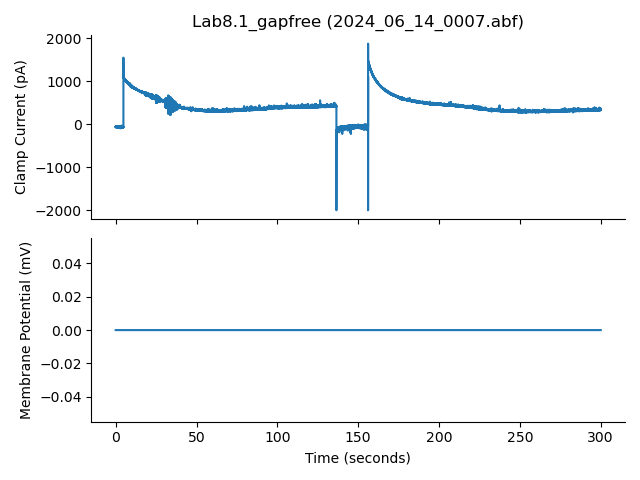

In [5]:
f = files[1]
plot_swps(f)

In [6]:
swps, swp_time, sr = get_sweeps(f)
zero = swp_window(swps,50,110,sr)[0]
zero -= np.mean(zero[:50])
zero_bis = swp_window(swps,200,300,sr)[0]
zero_bis -= np.mean(zero_bis[:50])

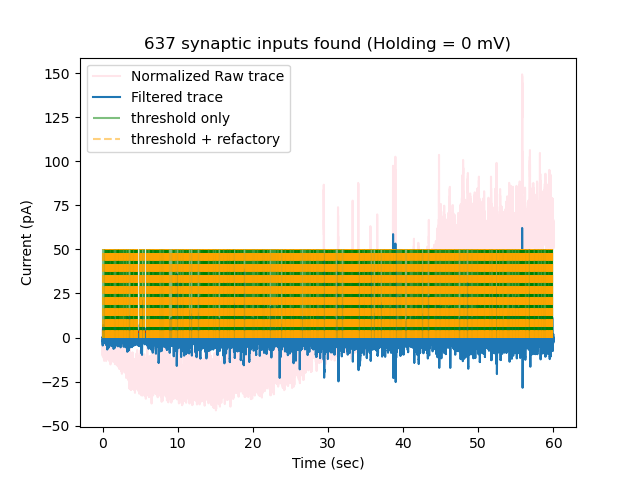

In [7]:
plt.close('all')
full_trace = zero
dt = 1/sr
full_filt = filtering.bandpass(full_trace, dt*1e3, 0.005,0.04)
thresh = 3
time = np.arange(len(full_trace))/sr
is_input = (full_filt[:-1]<thresh) * (full_filt[1:]>=thresh)
where_input = np.where(is_input)[0]
ref_t = 10e-3
refact = int(ref_t/dt)
ref = 0
where_syn = []
for i in where_input:
    if i<ref:
        continue
    else:
        syn = full_filt[i:i+refact]
    if syn.max() < thresh:
        continue
    else:
        where_syn.append(i)
        ref = i+refact
where_syn = np.array(where_syn)
fig,ax = plt.subplots()
ax.plot(time,full_trace,alpha=0.4,color='pink',label='Normalized Raw trace')
ax.plot(time,full_filt,label='Filtered trace')
ax.hlines(thresh,time[1],time[-1],alpha=0.7,color='red',linestyles='solid')
ax.vlines(where_input*dt,0,50,alpha=0.5,color='green',linestyles='solid')
ax.vlines(where_syn*dt,0,50,alpha=0.8,color='orange',linestyles='dashed')
#Legend
ax.vlines(0,0,0,alpha=0.5,color='green',linestyles='solid',label='threshold only')
ax.vlines(0,0,0,alpha=0.5,color='orange',linestyles='dashed',label='threshold + refactory')
ax.set_title(f'{len(where_syn)} synaptic inputs found (Holding = 0 mV)')
ax.set_ylabel('Current (pA)')
ax.set_xlabel('Time (sec)')
ax.legend()
plt.show()

In [ ]:
before = 2 # ms
after = 50 # ms
i_b = int(before*1e-3/dt)
i_a = int(after*1e-3/dt)
where_syn = where_syn[where_syn<(len(full_trace)-i_a)]
synaptic_input = np.array([full_trace[syn_i:syn_i+i_a]-np.mean(full_trace[syn_i-i_b])  
                           for syn_i in where_syn])

fig,ax = plt.subplots()
time = np.arange(len(synaptic_input[0]))/sr
ax.plot(time*1e3,synaptic_input[0])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Current (pA)')

In [32]:
plt.close('all')
full_trace = zero
fs = sr
full_filt = filtering.bandpass(full_trace, dt*1e3, 0.001,0.1)

# Define the signal variable: current or voltage (raw or processed)
peaks_signal = full_filt # trace after pre-processing 
 
# You could also select a range of the trace with the below option
# peaks_signal = current_filtered[5000:50000]
 
# Event window parameters
event_no = 0  # Event viewer: 0 is the first event
pretrigger_window = (3 * fs)/1000  # Pre-event time window in ms
posttrigger_window = (100 * fs)/1000  # Post-event time window in ms
 
# Set parameters of the Find peaks function
thresh_min = 5
thresh_max = 120
thresh_prominence = 8
thresh_min_width = 1 * (fs/1000)
 
# Find peaks function
peaks, peaks_dict = find_peaks(-peaks_signal, 
           height=(thresh_min, thresh_max),  # Min and max thresholds to detect peaks.
           threshold=None,  # Min and max vertical distance to neighboring samples.
           distance=None,  # Min horizontal distance between peaks.
           prominence=thresh_prominence,  # Vertical distance between the peak and lowest contour line.
           width=thresh_min_width,  # Min required width (in bins). E.g. For 10Khz, 10 bins = 1 ms.
           wlen=None,  # Window length to calculate prominence.
           rel_height=0.5,  # Relative height at which the peak width is measured.
           plateau_size=None)
  
# Create table with results
table = pd.DataFrame(columns = ['event', 'peak_index', 
                                'peak_time_s',
                                'event_window_start', 'event_window_end',
                                'peak_amp', 'width_ms', 
                                'inst_freq', 'isi_s', 
                                'area', 'decay_tau_log', 
                                'decay_tau_exp', 'rise_tau_exp'])
  
table.event = np.arange(1, len(peaks) + 1)
table.peak_index = peaks
table.peak_time_s = peaks / fs  # Divided by fs to get s
table.event_window_start = peaks_dict['left_ips'] - pretrigger_window
table.event_window_end = peaks_dict['right_ips'] + posttrigger_window
table.peak_amp = peaks_dict['peak_heights']  # height parameter is needed
table.width_ms = peaks_dict['widths']/(fs/1000) # Width (ms) at half-height
 
# Additional parameters (remember to add the columns to the dataframe)
# table.rise_half_amp_ms = (peaks - peaks_dict['left_ips'])/(fs/1000) 
# table.decay_half_amp_ms = (peaks_dict['right_ips'] - peaks)/(fs/1000)
  
# Calculations based on the parameters above
table.inst_freq = np.insert((1 / (np.array(table.peak_index[1:]) -
                                  np.array(table.peak_index[:-1])) * fs), 
                            0, np.nan) 
 
table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
 
for i, event in table.iterrows():
     
    # Event area as absolute value (abs)
    individual_event = peaks_signal[int(event.event_window_start) : int(event.event_window_end)]
    table.loc[i, 'area'] = abs(round(individual_event.sum()/(fs/1000), 2))  # pA x ms
     
    # Decay tau from logistic regression
    decay_tau = abs(peaks_signal[int(event.peak_index) : int(event.event_window_end)])
    decay_tau_log = np.log(decay_tau)
    decay_width = int(len(decay_tau))
    decay_width_array = list(range(0, decay_width))
    slope, _ = np.polyfit(decay_width_array, decay_tau_log, 1)
    tau = -1 / slope
    table.loc[i, 'decay_tau_log'] = tau/(fs/1000) 
 
    # Decay tau from monoexponential fitting
    decay_tau = peaks_signal[int(event.peak_index) : int(event.event_window_end)]
    decay_width = int(len(decay_tau))
    decay_width_array = list(range(0, decay_width))
    a_initial = 200
    b_initial = 0.1
    # popt: optimal values for the parameters, pcov: estimated covariance of popt
    popt, pcov = curve_fit(lambda t, a, b: a * np.exp(b * t), 
                           decay_width_array, decay_tau, 
                           p0=(a_initial, b_initial), 
                           maxfev=2000)  # maxfev: number of iterations
    a = popt[0]  
    b = popt[1]      
    table.loc[i, 'decay_tau_exp'] = abs((1/b)/(fs/1000))
     
    # Rise tau from monoexponential fitting
    rise_tau = peaks_signal[int(event.event_window_start):int(event.peak_index)]
    rise_width = int(len(rise_tau))
    rise_width_array = list(range(0, rise_width))
    a_initial = 200
    b_initial = 0.1
    # popt: optimal values for the parameters, pcov: estimated covariance of popt
    popt, pcov = curve_fit(lambda t, a, b: a * np.exp(b * t), 
                           rise_width_array, rise_tau, 
                           p0=(a_initial, b_initial), 
                           maxfev=2000)  # maxfev: number of iterations
    a = popt[0]  
    b = popt[1]      
    table.loc[i, 'rise_tau_exp'] = abs((1/b)/(fs/1000))


/home/alan/miniforge3/envs/CSHL/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1003: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/home/alan/miniforge3/envs/CSHL/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/alan/miniforge3/envs/CSHL/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1041: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq
/home/alan/miniforge3/envs/CSHL/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1003: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/home/alan/miniforge3/envs/CSHL/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/alan/miniforge3/envs/CSHL/lib/python3.12/site-packages/scipy/o

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.

In [31]:
table

,event,peak_index,peak_time_s,event_window_start,event_window_end,peak_amp,width_ms,inst_freq,isi_s,area,decay_tau_log,decay_tau_exp,rise_tau_exp
0,1,1841,0.1841,1282.080436,4388.939314,5.481240,207.685888,NaN,0.0000,NaN,NaN,NaN,NaN
1,2,7534,0.7534,7308.033924,8760.445817,6.190444,42.241189,1.756543,0.5693,NaN,NaN,NaN,NaN
2,3,8442,0.8442,8103.366424,9996.158585,6.708452,86.279216,11.013216,0.0908,NaN,NaN,NaN,NaN
3,4,10551,1.0551,9710.205592,11778.494246,7.148873,103.828865,4.741584,0.2109,NaN,NaN,NaN,NaN
4,5,12918,1.2918,12190.215817,14092.999827,5.824060,87.278401,4.224757,0.2367,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,392,594226,59.4226,593822.578273,595334.578921,8.842179,48.200065,11.820331,0.0846,NaN,NaN,NaN,NaN
392,393,595196,59.5196,594786.676676,596546.665085,11.943254,72.998841,10.309278,0.0970,NaN,NaN,NaN,NaN
393,394,596689,59.6689,596338.408100,597802.602355,12.333327,43.419426,6.697924,0.1493,NaN,NaN,NaN,NaN
394,395,597358,59.7358,597030.884667,598420.835038,11.950206,35.995037,14.947683,0.0669,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Current (pA)')

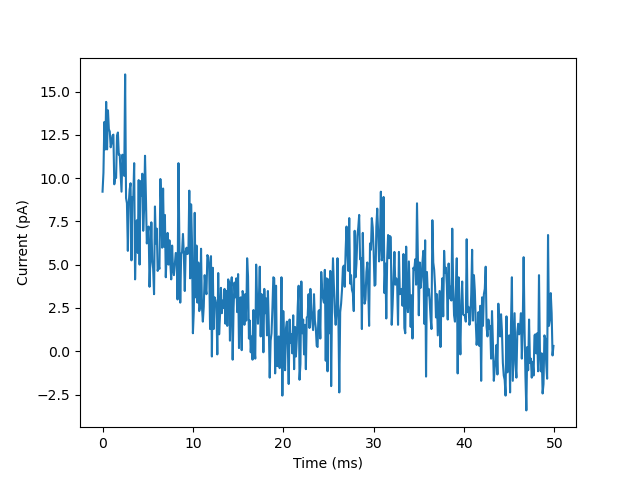